In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

Instructions for updating:
non-resource variables are not supported in the long term


# Introduction
최근접 이웃 방법은 거리 개념에 기초를 둔 방법이다. 훈련세트에서 각 데이터 포인트들이 얼마나 가까이에 위치하는지를 고려해 예측을 만들어낸다. 가장 간단한 방법에서 예측 클래스는 가장 가까운 데이터 포인트 클래스와 같다.<br>
하지만 거의 대부분의 데이터셋은 어느정도의 노이즈를 포함한다. 그렇기 때문에 k개의 최근접 이웃들의 평균을 취해서 예측을 하는 k최근접 이웃 알고리즘을 사용한다. 실제적인 방법은 우리가 회귀 문제를 수행하느냐 분류 문제를 수행하느냐에 의존한다.

분류 문제의 경우 voting scheme을 최대화함으로서 예측을 수행하는데 그 식은 다음과 같다.<br>
$f(z) = max_j \sum_{i=1}^k \phi(d_{ij})I_{ij}$<br>
$f(z)$는 모든 클래스들,j에 대해 maximum weighted value이다. 여기서 예측 지점에서 훈련 지점 i까지의 weighted distance(가중 거리)는 $\phi(d_{ij})$로 주어지며, $I_{ij}$는 데이터 포인트 i가 클래스 j에 있는지 나타내는 indicator function이다. 

회귀 문제의 경우 예측은 k개의 가장 가까운 것들의 가중 평균으로 구해진다.<br>
$f(z)={1 \over k}\sum_{i=1}^k \phi(d_i)y_{i}$

distance metric의 선택 역시 매우 중요한 것은 확실하다. 여기서는 L1과 L2 norm을 사용하도록 한다.

어떻게 거리를 재는지 방법 역시 선택해야하는데 직접적으로 거리 자체를 재는 방법도 있겠으나 멀리 떨어진 포인트는 훨씬 작은 영향을 미치게 된다. 가장 흔한 방법은 거리의 역수를 정규화하는 것이다.

k최근접 이웃은 집계의 방식을 사용하기 때문에 예측이 실제 값에 비해서 덜 극적이고 덜 변화할 것이다. 이 영향의 정도는 k의 선택에 따라 결정될 것이다.

# Working with nearest-neighbors
수치적인 특징과 연속적인 타겟값을 갖는 데이터를 가지고 실습

In [2]:
# 1. 
import requests
sess = tf.Session()

# 2. 
housing_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
housing_header = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
cols_used = ['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']

num_features = len(cols_used)

housing_file = requests.get(housing_url)
housing_data = [[float(x) for x in y.split(' ') if len(x)>=1] for y in housing_file.text.split('\n') if len(y)>=1]

# 3. MEDV(집값의 평균)을 예측, ZN,CHAS,RAD는 사용하지 않음
y_vals = np.transpose([np.array([y[13] for y in housing_data])])
x_vals = np.array([[x for i,x in enumerate(y) if housing_header[i] in cols_used] for y in housing_data])
# min-max sacling (np.ptp는 range 곧 최대값-최소값)
x_vals = (x_vals - x_vals.min(0)) / x_vals.ptp(0)

# 4. 
from sklearn.model_selection import train_test_split
x_vals_train,x_vals_test,y_vals_train,y_vals_test = train_test_split(x_vals,y_vals,test_size = 0.2)

In [5]:
# 5. 최근접 이웃 4개를 사용한다.
k = 4
batch_size = len(x_vals_test)

# 6. 최근접 이웃 알고리즘에서는 train 시킬 모델 변수가 존재하지 않으며 training set으로부터 모델이 결정된다.
x_data_train = tf.placeholder(shape=[None,num_features],dtype=tf.float32)
x_data_test = tf.placeholder(shape=[None,num_features],dtype=tf.float32)
y_target_train = tf.placeholder(shape=[None,1],dtype=tf.float32)
y_target_test = tf.placeholder(shape=[None,1],dtype=tf.float32)

# 7 . distance 함수를 정의(여기서는 L1을 사용)
distance = tf.reduce_sum(tf.abs(tf.subtract(x_data_train,tf.expand_dims(x_data_test,1))),reduction_indices=2)

In [6]:
# 7 . distance 함수를 정의(여기서는 L1을 사용)
# expand_dims 함수는 지정한 위치(여기서는 1)에 차원을 추가
# 연산의 모양이 이해가 안가면 아래를 참조
# 테스트세트의 데이터들에서 훈련세트의 각각의 데이터들까지의 거리를 구하기 위해서임
distance = tf.reduce_sum(tf.abs(tf.subtract(x_data_train,tf.expand_dims(x_data_test,1))),reduction_indices=2)

In [7]:
sess.run(tf.expand_dims(tf.constant([[1,2],[3,4]]),1))

array([[[1, 2]],

       [[3, 4]]])

In [8]:
# 브로드캐스팅된 모습을 상상
sess.run(tf.subtract(tf.expand_dims(tf.constant([[1,2],[3,4]]),1),tf.constant([[1,2],[3,4]])))

array([[[ 0,  0],
        [-2, -2]],

       [[ 2,  2],
        [ 0,  0]]])

In [9]:
sess.run(tf.subtract(tf.constant([[1,2],[3,4]]),tf.expand_dims(tf.constant([[1,2],[3,4]]),1)))

array([[[ 0,  0],
        [ 2,  2]],

       [[-2, -2],
        [ 0,  0]]])

In [10]:
# 8. 예측 함수 정의, 이를 위해 top_k()라는 함수를 이용할 것인데 텐서에서 가장 큰 값들(k개)의 값과 인덱스를 반환해주는 함수이다.
# top_k_vals, top_k_indices는 2차원으로 생성된 텐서([None,k])
# 가장 작은 거리의 인덱스들을 구하기보다 k개의 가장 큰 negative distance를 구하도록 한다.
# prediction을 선언하고 MSE 역시 선언한다.

top_k_xvals, top_k_indices = tf.nn.top_k(tf.negative(distance),k=k)
# top k 개의 합->1차원으로 축소된 텐서를 2차원으로 확장: [None,1]
x_sums = tf.expand_dims(tf.reduce_sum(top_k_xvals,1),1)
# 식을 직접 작성해 확인 : x_sums가 axis=1 방향으로 4번 반복되는 모습
x_sums_repeated = tf.matmul(x_sums,tf.ones([1,k],tf.float32))
# 가장 큰 k개의 합으로 나눠 값들을 합이 1이 되도록 스케일링(가중평균의 가중치로 사용할 것임)
x_val_weights = tf.expand_dims(tf.divide(top_k_xvals,x_sums_repeated),1)

# gather : params에 입력 받은 벡터들 중 indices로 입력한 위치값들을 찾아 반환
top_k_yvals = tf.gather(params = y_target_train,indices = top_k_indices)
# squeeze 함수는 차원의 사이즈 중 값이 1인 것을 찾아 그 차원을 제거한다.
# batch_matmul이 책에 나와있는 코드지만 버전이 업데이트되며 사라졌다. 대신 matmul을 쓰기로한다.
prediction = tf.squeeze(tf.matmul(x_val_weights,top_k_yvals),squeeze_dims=[1])
# batch_size가 test_set의 길이 전부임
mse = tf.divide(tf.reduce_sum(tf.square(tf.subtract(prediction,y_target_test))),batch_size)

Instructions for updating:
Use the `axis` argument instead


In [11]:
'''from sklearn.datasets import load_iris
iris = load_iris()
vvv,iii = tf.nn.top_k(iris.data)
vvv.eval(session=tf.Session()).shape'''
''''''
# top_k_xvals가 이해 안가면 실행시켜보시오

''

In [12]:
# batch_matmul이 이해 안간다면 실행시켜 보시오
# matmul로 대체 가능
a = tf.constant([[[1,2],[3,4]],[[5,6],[7,8]]])
b = tf.constant([[[1],[2]],[[1],[2]]])
tf.squeeze(tf.matmul(a,b)).eval(session=tf.Session())

array([[ 5, 11],
       [17, 23]])

In [13]:
# 9.
num_loops = int(np.ceil(len(x_vals_test)/batch_size))
init = tf.global_variables_initializer()
sess.run(init)

for i in range(num_loops):
    min_index = i*batch_size
    max_index = min((i+1)*batch_size,len(x_vals_train))
    x_batch = x_vals_test[min_index:max_index]
    y_batch = y_vals_test[min_index:max_index]
    predictions = sess.run(prediction, feed_dict={x_data_train:x_vals_train,x_data_test:x_batch, 
                                                  y_target_train:y_vals_train,y_target_test:y_batch})
    batch_mse = sess.run(mse,feed_dict={x_data_train:x_vals_train,x_data_test:x_batch, 
                                                  y_target_train:y_vals_train,y_target_test:y_batch})
    print('Batch # {}, MSE : {}'.format(i+1,np.round(batch_mse,3)))
    print('min_index={} ,max_index={}'.format(min_index,max_index))

Batch # 1, MSE : 8.940999984741211
min_index=0 ,max_index=102


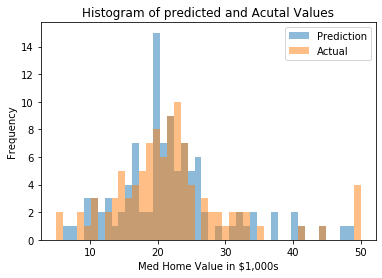

In [16]:
bins = np.linspace(5,50,45)
plt.hist(predictions,bins,alpha=0.5,label='Prediction')
plt.hist(y_batch,bins,alpha=0.5,label='Actual')
plt.title('Histogram of predicted and Acutal Values')
plt.xlabel('Med Home Value in $1,000s')
plt.ylabel('Frequency')
plt.legend(loc='best')

어려운 것 중 하나는 적절한 k를 선택하는 것이다. k가 4(예시임)정도까지는 MSE가 감소하다가 그 이상 커질수록 MSE는 커지나 예측의 변동이 작아지는 것을 확인할 수 있다.

최근접 알고리즘에서 모델은 훈련세트 그 자체이다. 그렇기에 모델에서 다른 변수를 훈련시킬 필요가 없다. cross-validation을 통해 적절한 k만 결정한다면 MSE를 최소화할 수 있다.

위의 예시에서 k최근접 이웃 알고리즘에서 가중치를 거리(distance)에 기반해 바로 선택했으나 다른 방법들 역시 고려할 수 있다. 흔한 방법 중 하나는 거리의 제곱 행렬의 역행렬로 가중치를 갖는 것이다.

# Working with text based distances
Levenshtein distance(edit distance)라는 것을 사용해 텐서플로우에서 어떻게 텍스트 간의 거리를 측정하는지 알아보도록 한다.<br>
최근접 이웃 방법에서 텍스트를 갖는 특징들을 포함해 사용하기 위해 중요한 개념이다.

Levenstein 거리는 한 string에서 다른 string으로 가기 위한 최소한의 단계의 숫자를 뜻한다. 문자를 삽입하거나 삭제하거나 다른 것으로 대체하는 등의 편집이 허용된다. 텐서플로우에서는 edit_distance() 함수로 구현되어있다. 단 edit_distance 함수를 사용하기 위해서 각각의 문자를 sparse한 텐서로 만들 필요가 있다.

In [34]:
# 1. 
# 2. 두 단어 간 거리가 어떻게 계산되는지 확인하기 위해 beer와 beer라는 문자열 리스트를 만들고 3D 행렬로 바꾼다.
# 입력해야할 파라미터로는 문자 인덱스들, 행렬의 모양, 텐서에서 어떤 문자를 우리가 원하는지
# normalize =True:정규화된 거리를 구할지(두번째 단어의 글자 수로 나눈 것) False:전체적인 거리를 구할지 결정
hypothesis = list('bear')
truth = list('beers')
# SparseTensor : 입력한 index들에 value를 채워넣고 나머지는 전부 0으로 채워넣음(?)
# dense_shape=[1,1,1], 1x1x1개의 원소를 갖는 3차원 텐서
h1 = tf.SparseTensor(indices=[[0,0,0],[0,0,1],[0,0,2],[0,0,3]],values=hypothesis,dense_shape=[1,1,1])
t1 = tf.SparseTensor([[0,0,0],[0,0,1],[0,0,2],[0,0,3],[0,0,4]],truth,[1,1,1])

sess.run(tf.edit_distance(h1,t1,normalize=False))

array([[2.]], dtype=float32)

In [20]:
t1.eval(session=tf.Session())

SparseTensorValue(indices=array([[0, 0, 1],
       [0, 0, 2],
       [0, 0, 2],
       [0, 0, 3],
       [0, 0, 4]], dtype=int64), values=array([b'b', b'e', b'e', b'r', b's'], dtype=object), dense_shape=array([1, 1, 1], dtype=int64))

In [44]:
# 3. 
hypothesis2 = list('bearbeer')
truth2 = list('beersbeers')
h2 = tf.SparseTensor([[0,0,0],[0,0,1],[0,0,2],[0,0,3],[0,1,0],[0,1,1],[0,1,2],[0,1,3]],hypothesis2,[1,2,4])
# indices
# 단어 하나하나마다의 인덱스 : 1번째 컬럼(아래 셀 참고),
# 한 단어내에서 의미가 끊기는 단위 : 2번째 컬럼,
# 각 (끊어진) 단어에 대한 길이 : 3번째 컬럼(?)
# dense_shape 파라미터는 몇 개의 단어가 몇 개의 의미로 끊기고 각 몇 글자씩인지 나타내는 듯
# value에는 1차원 리스트를 넣음
t2 = tf.SparseTensor([[0,0,0],[0,0,1],[0,0,2],[0,0,3],[0,0,4],[0,1,0],[0,1,1],[0,1,2],[0,1,3],[0,1,4]],truth2,[1,2,5])

sess.run(tf.edit_distance(h2,t2,normalize=True))

array([[0.4, 0.2]], dtype=float32)

In [45]:
sess.run(tf.edit_distance(h2,t2,normalize=False))
# bear과 beers는 두 번의 수정
# beer과 beers는 한 번의 수정

array([[2., 1.]], dtype=float32)

In [42]:
# 3. 
hypothesis2 = list('pokaricolaik')
truth2 = list('pokalymcokecok')
h2 = tf.SparseTensor([[0,0,0],[0,0,1],[0,0,2],[0,0,3],[0,0,4],[0,0,5],[0,1,0],
                      [0,1,1],[0,1,2],[0,1,3],[0,1,4],[0,1,5]],
                     hypothesis2,[1,2,6])

t2 = tf.SparseTensor([[0,0,0],[0,0,1],[0,0,2],[0,0,3],[0,0,4],[0,0,5],[0,0,6],
                      [0,1,0],[0,1,1],[0,1,2],[0,1,3],[0,1,4],[0,1,5],[0,1,6]],
                     truth2,[1,2,7])

sess.run(tf.edit_distance(h2,t2,normalize=False))
#pokari, pokalym
#colaik, cokecok

array([[3., 4.]], dtype=float32)

In [43]:
sess.run(tf.edit_distance(h2,t2,normalize=True))

array([[0.42857143, 0.5714286 ]], dtype=float32)

In [46]:
# 4. 두 words의 세트를 다른 word로부터 비교하는 더 효과적인 방법

hypothesis_words = ['bear','bar','tensor','flow']
truth_word = ['beers']
num_h_words = len(hypothesis_words)

h_indices = [[xi,0,yi] for xi,x in enumerate(hypothesis_words) for yi,y in enumerate(x)]
h_chars = list(''.join(hypothesis_words))
h3 = tf.SparseTensor(h_indices,h_chars,[num_h_words,1,1])

# truth_word의 원소가 하나 뿐이니 비교를 위해 4개로 확장
truth_word_vec = truth_word*num_h_words

t_indices = [[xi,0,yi] for xi,x in enumerate(truth_word_vec) for yi,y in enumerate(x)]
t_chars = list(''.join(truth_word_vec))
t3 = tf.SparseTensor(t_indices,t_chars,[num_h_words,1,1])

sess.run(tf.edit_distance(h3,t3,normalize=True))

array([[0.4],
       [0.6],
       [1. ],
       [1. ]], dtype=float32)

In [23]:
# 5. placeholder를 이용해 어떻게 두 단어 리스트 간 edit distance를 계산하는지 살펴본다.
# 다른 모든 것은 동일하나 sparse tensor 대신 SparseTensorValue()를 사용한다.

def create_sparse_vec(word_list):
    num_words = len(word_list)
    indices = [[xi,0,yi] for xi,x in enumerate(word_list) for yi,y in enumerate(x)]
    chars = list(''.join(word_list))
    return (tf.SparseTensorValue(indices,chars,[num_words,1,1]))

hyp_string_sparse = create_sparse_vec(hypothesis_words)
truth_string_sparse = create_sparse_vec(truth_word*len(hypothesis_words))

hyp_input = tf.sparse_placeholder(dtype=tf.string)
truth_input = tf.sparse_placeholder(dtype=tf.string)

edit_distances = tf.edit_distance(hyp_input,truth_input,normalize=True)

feed_dict = {hyp_input:hyp_string_sparse, truth_input:truth_string_sparse}

sess.run(edit_distances,feed_dict=feed_dict)

array([[0.4],
       [0.6],
       [1. ],
       [1. ]], dtype=float32)

거리를 계산하는 여러 가지 방법으로는
- Hamming distance : $D(s_1,s_2) = \sum_{i}I_i$,  $I$는 두 문자가 같은지 아닌지 나타내는 indicator 함수다.
- Cosine distance
- Jacard distance

# Computing with mixed distance functions
만일 여러 개의 feature들을 가지고 있는 데이터를 다룬다면 각 feature들은 다르게 스케일링 될 수 있다고 인지해야한다.

이번 section에서 housing value prediction을 어떻게 향상시킬 수 있는지 살펴보도록 한다.

최근접 알고리즘에서는 변수들을 다르게 스케일링 해주는 것이 중요하다. 특히 이번 section에서 볼 것은 feature variance를 사용해 거리 를 스케일하는 것이다.
<br>다음과 같은 weight matrix를 사용한다.
$D(x,y) = \sqrt{{(x-y)}^T{\cdot}A{\cdot}(x-y)}$
<br>여기서 A는 각각의 feature에 대해서 거리 metirc을 스케일하는데 사용되는 diagonal weight matrix다.

In [168]:
# 1. 
sess = tf.Session()

# 2. 
housing_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
housing_header = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
cols_used = ['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']

num_features = len(cols_used)

housing_file = requests.get(housing_url)
housing_data = [[float(x) for x in y.split(' ') if len(x)>=1] for y in housing_file.text.split('\n') if len(y)>=1]

# 3. MEDV(집값의 평균)을 예측, ZN,CHAS,RAD는 사용하지 않음
y_vals = np.transpose([np.array([y[13] for y in housing_data])])
x_vals = np.array([[x for i,x in enumerate(y) if housing_header[i] in cols_used] for y in housing_data])

In [169]:
# 3. 스케일링
x_vals = (x_vals - x_vals.min(0))/x_vals.ptp(0)

In [170]:
# 4. diagonal-weight matrix 생성 : distance metric에 대해 각 특징들의 표준편차로 나누는 스케일링을 제공
weight_diagonal = x_vals.std(axis = 0)
# cast는 텐서로 반환(type을 tf.float32)
weight_matrix = tf.cast(tf.diag(weight_diagonal),dtype=tf.float32)

In [173]:
# 5. 
from sklearn.model_selection import train_test_split
x_vals_train,x_vals_test,y_vals_train,y_vals_test = train_test_split(x_vals,y_vals,test_size=0.2)

k = 4
batch_size = len(x_vals_test)

# 6. x,y의 train,test 각 placeholder->4개
x_data_train = tf.placeholder(shape=[None,num_features],dtype=tf.float32)
x_data_test = tf.placeholder(shape=[None,num_features],dtype=tf.float32)
y_target_train = tf.placeholder(shape=[None,1],dtype=tf.float32)
y_target_test = tf.placeholder(shape=[None,1],dtype=tf.float32)

In [174]:
# 7. distance function을 정의 (가독성 좋게 몇 개 요소로 나눠서 정의)
# 완벽하게 이해하기는 어려우므로 대강 이해(그래도 대강은 이해하고 넘어갈 것..)

# 행의 개수가 다른데 test 데이터의 차원을 확장함으로서 계산가능
# 공식에서의 (x-y)^T(?): shape : [batch_size,train 데이터 개수,num_features]
subtraction_term = tf.subtract(x_data_train,tf.expand_dims(x_data_test,1))

# tile : 앞의 행렬을 하나처럼 취급하고 그 행렬이 뒤의 파라미터인 사이즈만큼 이어붙혀지도록 한다.
first_product = tf.matmul(subtraction_term, tf.tile(tf.expand_dims(weight_matrix,0),[batch_size,1,1]))

second_product = tf.matmul(first_product,tf.transpose(subtraction_term,perm=[0,2,1]))
distance = tf.sqrt(tf.matrix_diag_part(second_product))

In [175]:
# 연산이 이해가 안가면 참조
nn = tf.constant([[3,1],[4,1],[5,1],[6,1],[7,1],[8,1],[9,1],[10,1],[11,1],[12,1]])
mm = tf.constant([[1,2],[-1,2],[0,2]])

sess.run(tf.subtract(nn,tf.expand_dims(mm,1))).shape
# 10x2 - 3x1x2

(3, 10, 2)

In [176]:
# 8 .
top_k_xvals,top_k_indices = tf.nn.top_k(tf.negative(distance),k=k)
x_sums = tf.expand_dims(tf.reduce_sum(top_k_xvals,1),1)
x_sums_repeated = tf.matmul(x_sums,tf.ones([1,k],tf.float32))
x_val_weights = tf.expand_dims(tf.div(top_k_xvals,x_sums_repeated),1)

top_k_yvals = tf.gather(y_target_train,top_k_indices)

prediction = tf.squeeze(tf.matmul(x_val_weights,top_k_yvals),axis=[1])

# 9.
mse = tf.divide(tf.reduce_sum(tf.square(tf.subtract(prediction,y_target_test))),batch_size)

In [177]:
# 10.
init = tf.global_variables_initializer()
sess.run(init)
num_loops = int(np.ceil(len(x_vals_test)/batch_size))
for i in range(num_loops):
    min_index = i*batch_size
    max_index = min((i+1)*batch_size,len(x_vals_train))
    x_batch = x_vals_test[min_index:max_index]
    y_batch = y_vals_test[min_index:max_index]
    predictions = sess.run(prediction,feed_dict={x_data_train:x_vals_train,x_data_test:x_batch,
                                                y_target_train:y_vals_train, y_target_test:y_batch})
    batch_mse = sess.run(mse,feed_dict={x_data_train:x_vals_train,x_data_test:x_batch,
                                                y_target_train:y_vals_train, y_target_test:y_batch})
    print('Batch # {}, MSE: {}'.format(i+1,np.round(batch_mse,4)))

Batch # 1, MSE: 22.063800811767578


(5, 50)

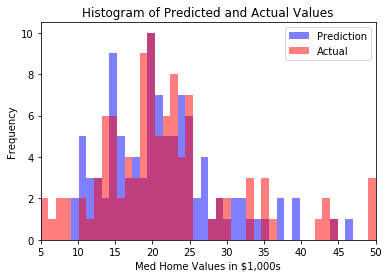

In [201]:
bins = np.linspace(5,50,45)
plt.hist(predictions,bins,alpha=0.5,label='Prediction',color='blue')
plt.hist(y_batch,bins,alpha=0.5,label='Actual',color='red')
plt.title('Histogram of Predicted and Actual Values')
plt.xlabel('Med Home Values in $1,000s')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.xlim(5,50)

# Using an address matching example
텍스트와 수치 특성을 모두 포함하는 경우

최근접 이웃은 주소 매칭에 있어서 가장 훌륭한 알고리즘이다. 주소 매칭에 있어서 오탈자, 다른 도시, 다른 ZIP 코드를 가지고 있으면서도 같은 주소를 가리키는 경우들이 있다. 최근접 이웃 알고리즘은 이런 경우 그것들이 실제로 같은 곳을 가리킨다는 것을 확인 시켜줄 수 있을 것이다. 

거리 주소와 ZIP 코드와 이루어진 두 데이터셋을 생성할 것인데 하나의 데이터셋은 거리 주소에서 매우 많은 오탈자를 가지고 있다. 오탈자가 없는 데이터셋을 gold standard로 취급하고 오탈자 주소로부터 가장 가까운 주소를 찾아낼 것이다. 거리 주소에 대해서는 string distance 함수, ZIP 코드에 대해서는 numerical distance의 함수를 이용한다.

In [72]:
# 1. 2. 데이터생성
import random
import string
n=10
street_names = ['abbey','baker','canal','donner','elm']
street_type = ['rd','st','ln','pass','ave']
rand_zips = [random.randint(65000,65999) for i in range(5)]

numbers = [random.randint(1,999) for i in range(n)]
streets = [random.choice(street_names) for i in range(n)]
street_suffs = [random.choice(street_type) for i in range(n)]
zips = [random.choice(rand_zips) for i in range(n)]

full_streets = [str(x)+' '+y+' '+z for x,y,z in zip(numbers,streets,street_suffs)]
reference_data = [list(x) for x in zip(full_streets,zips)]

In [73]:
reference_data

[['826 elm ave', 65400],
 ['553 elm st', 65484],
 ['345 elm ave', 65400],
 ['147 elm pass', 65400],
 ['577 elm rd', 65749],
 ['742 baker st', 65400],
 ['314 elm st', 65233],
 ['186 abbey ln', 65233],
 ['878 abbey rd', 65484],
 ['592 canal ln', 65426]]

In [74]:
# 3. test 데이터를 생성하기 위해 랜덤하게 오탈자를 만드는 함수를 정의
def create_typo(s,prob=0.75):
    if random.uniform(0,1)<prob:
        rand_ind = random.choice(range(len(s)))
        s_list = list(s)
        # string.ascii_lowercase는 알파벳 소문자 중 하나를 s의 랜덤한 인덱스에 집어넣는다.
        # (0.75의 확률로)
        s_list[rand_ind] = random.choice(string.ascii_lowercase)
        s = ''.join(s_list)
    return s
def create_diff_num(n,prob=0.75):
    if random.uniform(0,1)<prob:
        n += np.random.randint(500)
    else:
        n -= np.random.randint(500)
    return n

typo_streets = [create_typo(x) for x in streets]
for i in range(3):
    typo_streets = [create_typo(x) for x in typo_streets]
for i in range(4):
    zips = [create_diff_num(x) for x in zips]
typo_full_streets = [str(x)+' '+y+' '+z for x,y,z in zip(numbers,typo_streets,street_suffs)]
test_data = [list(x) for x in zip(typo_full_streets,zips)]

In [75]:
test_data

[['826 apy ave', 66470],
 ['553 lbm st', 65147],
 ['345 eli ave', 65988],
 ['147 glb pass', 65470],
 ['577 ypm rd', 65930],
 ['742 bascr st', 66467],
 ['314 ele st', 66156],
 ['186 aubet ln', 64859],
 ['878 abbfy rd', 66043],
 ['592 canuc ln', 65442]]

In [76]:
# 4. 네 개의 placeholder를 정의
test_address = tf.sparse_placeholder(dtype=tf.string)
test_zip = tf.placeholder(shape=[None,1],dtype=tf.float32)
ref_address = tf.sparse_placeholder(dtype=tf.string)
ref_zip = tf.placeholder(shape=[None,n],dtype=tf.float32)

# 5. numerical zip distance와 edit distance를 정의
zip_dist = tf.square(tf.subtract(ref_zip,test_zip))

address_dist = tf.edit_distance(test_address,ref_address,normalize=True)

In [77]:
# 6. zip distance와 address distance를 유사하게 바꾼다.
# 두 개가 완전히 같을 때는 1, 완전히 다를 때는 0과 가깝게

# test_zip의 원소들 기준으로 ref_zip 원소들과의 가장 먼 거리와 가장 짧은 거리 반환
zip_max = tf.gather(tf.squeeze(zip_dist),tf.argmax(zip_dist,1))
zip_min = tf.gather(tf.squeeze(zip_dist),tf.argmin(zip_dist,1))

# min-max
zip_sim = tf.divide(tf.subtract(zip_max,zip_dist),tf.subtract(zip_max,zip_min))
# 정규화된 edit_distance 기준으로 0이면 똑같은 단어이고, 1이면 아주 많이 수정해야하는 단어이므로 1을 빼준다.
address_sim = tf.subtract(1.,address_dist)

In [78]:
# 7. 두 유사도를 결합하기 위해 두 개의 가중평균을 취한다. 

# 일단은 동일한 가중치를 취하지만 우리가 어떤 것을 얼마나 더 신뢰하느냐에 따라 가중치 조정을 하면 된다.
# 가장 높은 유사도를 갖는 reference set에서의 index 반환
address_weight = 0.5
zip_weight = 1.-address_weight

weighted_sim = tf.add(tf.transpose(tf.multiply(address_weight,address_sim)),tf.multiply(zip_weight,zip_sim))
top_match_index = tf.argmax(weighted_sim,1)

In [79]:
# 8. edit distance를 이용하기 위해 sparse matrix로 바꿔주는 과정이 필요하다.
def sparse_from_word_vec(word_vec):
    num_words = len(word_vec)
    indices = [[xi,0,yi] for xi,x in enumerate(word_vec) for yi,y in enumerate(x)]
    chars = list(''.join(word_vec))
    return tf.SparseTensorValue(indices,chars,[num_words,1,1])

# 9. 주소와 zip code분리
reference_addresses = [x[0] for x in reference_data]
reference_zips = np.array([[x[1] for x in reference_data]])

In [80]:
# 10. 8번의 함수 실행
sparse_ref_set = sparse_from_word_vec(reference_addresses)

sess.run(init)
# 11. loop
for i in range(n):
    test_address_entry = test_data[i][0]
    test_zip_entry = [[test_data[i][1]]]
    # sparse address vector 생성
    test_address_repeated = [test_address_entry]*n
    sparse_test_set = sparse_from_word_vec(test_address_repeated)
    feeddict = {test_address:sparse_test_set,
               test_zip:test_zip_entry,
               ref_address:sparse_ref_set,
               ref_zip:reference_zips}
    best_match = sess.run(top_match_index,feed_dict=feeddict)
    best_street = reference_addresses[best_match[0]]
    [best_zip] = reference_zips[0][best_match]
    [[test_zip_]] = test_zip_entry
    print('Address : {}, {}'.format(test_address_entry,test_zip_))
    print('Match : {} , {}'.format(best_street,best_zip))

Address : 826 apy ave, 66470
Match : 826 elm ave , 65400
Address : 553 lbm st, 65147
Match : 553 elm st , 65484
Address : 345 eli ave, 65988
Match : 345 elm ave , 65400
Address : 147 glb pass, 65470
Match : 147 elm pass , 65400
Address : 577 ypm rd, 65930
Match : 577 elm rd , 65749
Address : 742 bascr st, 66467
Match : 742 baker st , 65400
Address : 314 ele st, 66156
Match : 577 elm rd , 65749
Address : 186 aubet ln, 64859
Match : 186 abbey ln , 65233
Address : 878 abbfy rd, 66043
Match : 878 abbey rd , 65484
Address : 592 canuc ln, 65442
Match : 592 canal ln , 65426


주소 매칭 문제를 이해하는데 있어서 가장 어려운 것은 가중치를 정하는 것과 어떻게 distance를 스케일링 하느냐이다. 이런 과정은 데이터 자체에 대한 탐색과 통찰이 될 수 있다. 또 실제 주소를 다룰 때 여기서 사용되지 않은 다른 요소를 사용하게 될 수도 있다. 거리 넘버를 거리 주소에서 분리된 무엇인가로 여길 수도 있고, 혹은 도시나 주 같은 다른 어떤 요소를 가질 수동 있다.<br>
(수치적인 데이터를 다룰 때 수치 그 자체로 계산할 수도 있지만 문자로서 생각해 edit distance를 계산할 수도 있을 것이다.)

# Using nearest-neighbors for image recognition
최근접 이웃 알고리즘은 이미지 인식에도 쓰일 수 있다. 다양한 신경망을 사용하게 되겠지만 신경망 없이 이미지 처리한 것에 대한 결과를 비교하는 것도 의미가 있을 것이다.

MNIST dataset을 이용한다 : 28x28(=784) pixel의 수천 개의 이미지로 이루어져있다.<br>
이번 절에서 k=4인 알고리즘을 이용해 예측을 수행하도록 한다.

In [1]:
# 1.
from PIL import Image

In [48]:
sess = tf.Session()

In [104]:
# 2.
from tensorflow import keras
mnist = keras.datasets.mnist
X_vals = mnist.load_data()

In [105]:
y_vals

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [106]:
x_vals = np.array(X_vals[0][0]).reshape(-1,784)
y_vals = np.array(X_vals[0][1])
print(x_vals.shape,y_vals.shape)

(60000, 784) (60000,)


In [107]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(y_vals.reshape(-1,1))
y_vals = encoder.transform(y_vals.reshape(-1,1)).toarray()

In [108]:
y_vals.shape

(60000, 10)

In [109]:
y_vals[0:3]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [110]:
# 3.
train_size = 1000
test_size = 102
rand_train_indices = np.random.choice(len(x_vals),train_size,replace=True)
rand_test_indices = np.random.choice(len(x_vals),test_size,replace=True)

x_vals_train = x_vals[rand_train_indices]
x_vals_test = x_vals[rand_test_indices]
y_vals_train = y_vals[rand_train_indices]
y_vals_test = y_vals[rand_test_indices]

In [111]:
x_vals_train.shape

(1000, 784)

In [174]:
# 4.
k = 4
batch_size = 6

# 5. 
x_data_train = tf.placeholder(shape=[None,28*28],dtype=tf.float32)
x_data_test = tf.placeholder(shape=[None,28*28],dtype=tf.float32)
y_target_train = tf.placeholder(shape=[None,10],dtype=tf.float32)
y_target_test = tf.placeholder(shape=[None,10],dtype=tf.float32)

# 6. L1 metric을 distance metric으로 사용
distance = tf.reduce_sum(tf.abs(tf.subtract(x_data_train,tf.expand_dims(x_data_test,1))),axis=2)

In [123]:
distance

<tf.Tensor 'Sum_15:0' shape=(?, ?) dtype=float32>

In [175]:
# 7.
# 각 test data에서 가장 가까운 train data 네개씩 할당: [batch_size,1000]의 shape
top_k_vals, top_k_indices = tf.nn.top_k(tf.negative(distance),k=k)
# 그 네 개에 대해 타깃값인 10개(one-hot)씩 할당 : [None,4,10]의 shape
prediction_indices = tf.gather(y_target_train,top_k_indices)
# 1번 차원에 대해 그 sum을 구함 : 가장 가까운 4개들을 합쳐서 값을 구함 : [None,10]의 shape
count_of_predictions = tf.reduce_sum(prediction_indices,reduction_indices=1)
# 10개짜리 원핫 인코딩이 더해져->[0,0,3,0,0,0,0,0,1,0]-> index 2를 출력(prediction)
prediction = tf.argmax(count_of_predictions,axis=1)

In [176]:
# 8.
num_loops = int(np.ceil(len(x_vals_test)/batch_size))
test_output = []
actual_vals = []

init = tf.global_variables_initializer()
sess.run(init)
for i in range(num_loops):
    min_index = i*batch_size
    max_index = min((i+1)*batch_size,len(x_vals_train))
    x_batch = x_vals_test[min_index:max_index]
    y_batch = y_vals_test[min_index:max_index]
    predictions = sess.run(prediction, feed_dict={x_data_train:x_vals_train,x_data_test:x_batch,
                                                 y_target_train:y_vals_train,y_target_test:y_batch})
    test_output.extend(predictions)
    actual_vals.extend(np.argmax(y_batch,axis=1))

In [158]:
sess.run(distance,feed_dict={x_data_train:x_vals_train,x_data_test:x_batch}).shape

(6, 1000)

In [159]:
sess.run(top_k_indices,feed_dict={x_data_train:x_vals_train,x_data_test:x_batch}).shape

(6, 4)

In [150]:
sess.run(top_k_vals,feed_dict={x_data_train:x_vals,x_data_test:x_batch})

array([[    -0.,  -2361.,  -2548.,  -2865.],
       [    -0.,  -9764., -10072., -10210.],
       [    -0., -10007., -10264., -10264.],
       [    -0., -11166., -11390., -11421.],
       [    -0.,  -7475.,  -8127.,  -8170.],
       [    -0.,  -9993., -11489., -11770.]], dtype=float32)

In [160]:
sess.run(prediction_indices,feed_dict={x_data_train:x_vals_train,x_data_test:x_batch,y_target_train:y_vals_train}).shape

(6, 4, 10)

In [162]:
sess.run(prediction_indices,feed_dict={x_data_train:x_vals_train,x_data_test:x_batch,y_target_train:y_vals_train})[0]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [161]:
sess.run(count_of_predictions,feed_dict={x_data_train:x_vals_train,x_data_test:x_batch,y_target_train:y_vals_train}).shape

(6, 10)

In [170]:
temp_onehot = sess.run(count_of_predictions,feed_dict={x_data_train:x_vals_train,x_data_test:x_batch,y_target_train:y_vals_train})
temp_onehot

array([[0., 4., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 2., 1.],
       [0., 0., 0., 0., 2., 0., 0., 0., 0., 2.],
       [4., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 4., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 2., 0., 0., 0., 0., 2.]], dtype=float32)

In [173]:
sess.run(tf.argmax(temp_onehot,axis=1))

array([1, 8, 4, 0, 4, 4], dtype=int64)

In [168]:
sess.run(prediction,feed_dict={x_data_train:x_vals_train,x_data_test:x_batch,y_target_train:y_vals_train})

array([3, 0, 0, 0, 4, 0, 0, 1, 1, 2], dtype=int64)

In [177]:
# 9.
accuracy = sum([1./test_size for i in range(test_size) if test_output[i]==actual_vals[i]])
print('test set에서의 정확도 : ' + str(accuracy))

test set에서의 정확도 : 0.8529411764705873


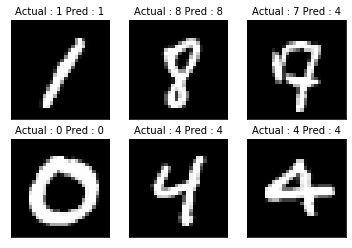

In [178]:
# 10.
actuals = np.argmax(y_batch,axis=1)
Nrows = 2
Ncols = 3
for i in range(len(actuals)):
    plt.subplot(Nrows,Ncols,i+1)
    plt.imshow(np.reshape(x_batch[i],[28,28]),cmap='Greys_r')
    plt.title('Actual : '+str(actuals[i])+ ' Pred : '+str(predictions[i]),fontsize=10)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)